# Self-Driving Car Engineer Nanodegree
## Project: Detecting Lane Lines

In this project, I was tasked with finding lane lines for a variety of images and videos of cars driving on highways. The approach, taken from the course lessons was to:
+ Take a blurred, grayscale image
+ find the edges of the image using canny
+ apply a mask over the region of interest - essentially the lane segment in front of the car, to lose other edges from the image
+ run hough transform over the image to isolate lines and then extrapolate the lines by separating negative and positive line slopes and averaging over these 2 line collections to create a single left and single right line
+ manage a buffer of N lines for use with video processing to smooth jittery lines
+ draw the lines onto the image

## Import Packages

In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


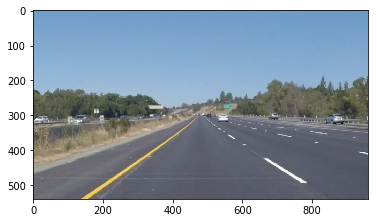

In [2]:
def show_image(img):
    #reading in an image
    image = mpimg.imread(img)

    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

# made this a function as wanted to remove global variable image
show_image(img)

## Lane Detector Class
I created this class to manage the helper functions and image processing function used in the video processing. This to allow me to pass in different variables for region of interest and also to control the line buffer size for smooting video lines.

In [3]:
class lane_detector:
    
    # initialise the class with default variable values unless passed from calling function
    def __init__(self, buffer_size=24, output_type=None, region=[.83, .104, 1, .60]):
        """ 
            the buffers will contain the line buffers for negative and positive slope lines
            the buffer size controls over how many frame lines the output lines will be averaged
            the output type controls which image to output
                edges - the canny algrorithm output
                masked - canny edges for region if interest
                blurred - grayscale and gaussian image
                None - final image
            the region controls the region of interest mask size
                array of x1,x2,y1,y2 used to mark the 4 sided region in x1,y1; x1,y2; x2,y2; x2,y1
        """
        self.neg_buffer = []
        self.pos_buffer = []
        self.buffer_size = buffer_size
        self.output_type = output_type
        self.region = region
        
    def buffer_line(self, buffer, line):
        """ 
            takes a line and adds it to buffer if not NONE, 
            returns the buffer to max size from last to first
        """
        if np.all(line):
            buffer.append(line)
        return buffer[-self.buffer_size:]
        
    def grayscale(self, img):
        """Applies the Grayscale transform
        This will return an image with only one color channel
        but NOTE: to see the returned image as grayscale
        (assuming your grayscaled image is called 'gray')
        you should call plt.imshow(gray, cmap='gray')"""
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Or use BGR2GRAY if you read an image with cv2.imread()
        # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    def gaussian_blur(self, img, kernel_size):
        """
            Applies a Gaussian Noise kernel
            The kernel size can be altered in the Process_Image() function
        """
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
    def canny(self, img, low_threshold, high_threshold):
        """
            Applies the Canny transform
            low and high threshold can be alteretd in Process_Image()
            recommendations are for the ratio between the 2 to be 1:2 or 1:3
        """
        return cv2.Canny(img, low_threshold, high_threshold)
    
    def region_of_interest(self, img, vertices):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        vertices can be controlled by passing a region array to the lane detector
        before calling Process_Image()
        """
        #defining a blank mask to start with
        mask = np.zeros_like(img)   

        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image
    
    def draw_lines(self, img, lines, color=[255, 0, 0], thickness=8):
        """
            Draws lines detected by Hough Transform processing onto a image mask
            Prior to drawing, 2 further processes applied:

            Line segments separated by slope ((y2-y1)/(x2-x1)) to decide which segments 
            are part of the left line vs. the right line. Then, averaged and extrapolated 
            to the top and bottom of the lane.

            Then a buffer of previous lines is maintained on the lane detection class
            over which each line is averaged to produce a smoothed line output - for video

            This function draws `lines` with `color` and `thickness`.    
            Lines are drawn on the image inplace (mutates the image).
            Using weighted drawing in the final step to achieve a transparent line
        """
        #create 2 empty arrays for the left and right lane lines
        neg = np.empty([1,3])
        pos = np.empty([1,3])
        
        #iterate over each line
        for line in lines:
            #find the equation of each line
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                intercept = y1 - slope*x1
                line_length = np.sqrt((y2-y1)**2+(x2-x1)**2)
                #put the lines into their correct array based on the direction of the slope
                if slope < 0:
                    neg = np.append(neg,np.array([[slope, intercept, line_length]]),axis = 0)
                elif slope > 0:
                    pos = np.append(pos,np.array([[slope, intercept, line_length]]),axis = 0)

        ## calculate the weighted average of the slopes and intercepts based on the length of the line segment
        ## and add to the line buffer
        self.neg_buffer = self.buffer_line(self.neg_buffer, 
                                            np.dot(neg[1:,2],neg[1:,:2])/np.sum(neg[1:,2]) if len(neg[1:,2]) > 0 else None)
        self.pos_buffer = self.buffer_line(self.pos_buffer, 
                                            np.dot(pos[1:,2],pos[1:,:2])/np.sum(pos[1:,2]) if len(pos[1:,2]) > 0 else None)
        
        # take the mean of each matrix column to return an averaged line over each buffer
        neg_lines = np.mean(self.neg_buffer, axis=0)
        pos_lines = np.mean(self.pos_buffer, axis=0)
                
        # function to create x,y points from line equations
        def get_points(lines):   
            #handle any NaN in the lines
            lines = np.nan_to_num(lines)
            y1 = img.shape[0] # bottom of the image
            y2 = y1*0.6         # slightly lower than the middle
            # make sure everything is integer as cv2.line requires it
            # handle if x is 0 as that would cause NaN
            if lines[0] == 0:
                x1 = 0
                x2 = 0
            else:
                x1 = int((y1 - lines[1])/lines[0])
                x2 = int((y2 - lines[1])/lines[0])
            y1 = int(y1)
            y2 = int(y2)
            return ((x1,y1),(x2,y2))

        # draw the left and right lines onto the image
        cv2.line(img, get_points(neg_lines)[0], get_points(neg_lines)[1], color, thickness)
        cv2.line(img, get_points(pos_lines)[0], get_points(pos_lines)[1], color, thickness)
    
    def hough_lines(self, img, rho, theta, threshold, min_line_len, max_line_gap):
        """
        `img` should be the output of a Canny transform.
        Returns an image with hough lines drawn.
        """
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        
        # create an image mask for the lines to be drawn onto
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        self.draw_lines(line_img, lines)
        return line_img
    
    def process_image(self, image):
        """
            main function of lane detector which calls each process in turn
        """
        # set up some params:
        kernel_size = 3
        low_threshold = 50
        high_threshold = 150
        
        # create blurred and grayscaled image and return it if that was asked for
        blurred = self.gaussian_blur(self.grayscale(image), kernel_size)
        if self.output_type=='blurred': return np.dstack((blurred, blurred, blurred))
        
        # get the canny edge image after blurring and grayscale applied
        edges = self.canny(blurred, low_threshold, high_threshold)
        if self.output_type == 'edges': return np.dstack((edges, edges, edges))        
        
        # define region of interest - allowed for different region stored in class variable region
        imshape = image.shape
        vx1 = int((imshape[1]-self.region[0]*imshape[1])/2)
        vx2 = int((imshape[1]-self.region[1]*imshape[1])/2)
        vy1 = int(imshape[0]*self.region[2])
        vy2 = int(imshape[0]*self.region[3])
        vertices = np.array([[(vx1,vy1),(vx2, vy2), (imshape[1]-vx2, vy2), (imshape[1]-vx1,vy1)]], dtype=np.int32)
        masked_edges = self.region_of_interest(edges, vertices)
        if self.output_type == 'masked': return np.dstack((masked_edges, masked_edges, masked_edges))
        
        if self.output_type == 'masked_segments': 
            masked_edges = np.dstack((masked_edges, masked_edges, masked_edges))
            return cv2.addWeighted(image, 0.5, masked_edges, 0.5, 0)
        
        # Define the Hough transform parameters
        rho = 1 # distance resolution in pixels of the Hough grid
        theta = np.pi/180 # angular resolution in radians of the Hough grid
        threshold = 10     # minimum number of votes (intersections in Hough grid cell)
        min_line_length = 5 #minimum number of pixels making up a line
        max_line_gap = 1    # maximum gap in pixels between connectable line segments

        # Run Hough on edge detected image
        lines = self.hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
                    
        # default output
        return cv2.addWeighted(image, 0.5, lines, 0.5, 0)        

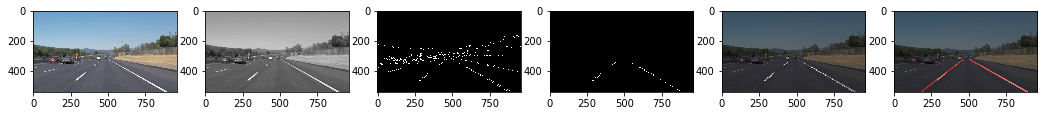

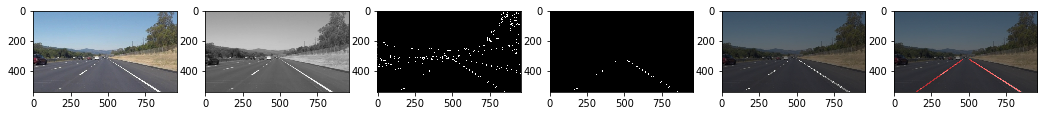

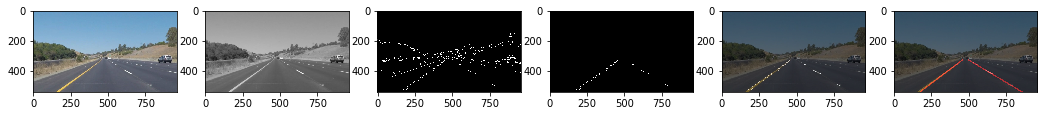

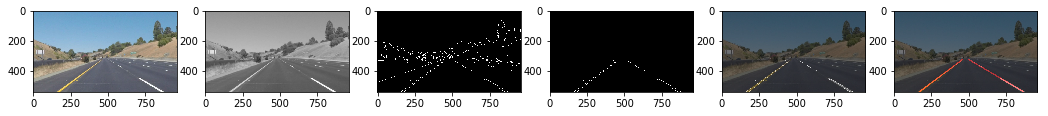

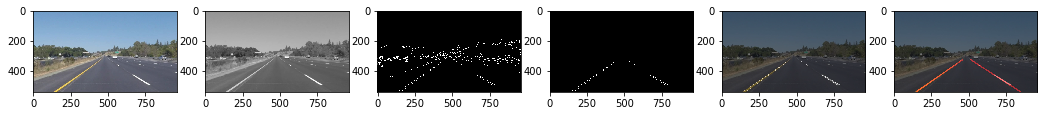

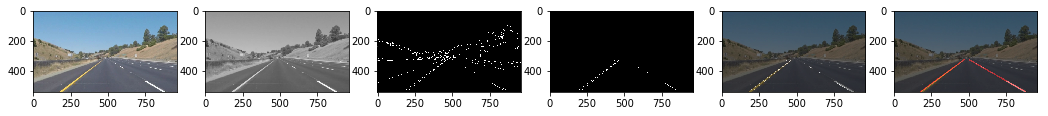

In [4]:
# show base image and output image for each test image
input_files = os.listdir("test_images/")

for i, img in enumerate(input_files):
    # read image and then show each step output
    detector = lane_detector()
    plt.figure(i+1, figsize=(18,12))
    image = mpimg.imread('test_images/'+img)

    plt.subplot(161)
    plt.imshow(image)

    plt.subplot(162)
    # select output style - None = finished image
    detector.output_type='blurred'
    plt.imshow(detector.process_image(image))
    
    plt.subplot(163)
    # select output style - None = finished image
    detector.output_type='edges'
    plt.imshow(detector.process_image(image))
    
    plt.subplot(164)
    # select output style - None = finished image
    detector.output_type='masked'
    plt.imshow(detector.process_image(image))
    
    plt.subplot(165)
    # select output style - None = finished image
    detector.output_type='masked_segments'
    plt.imshow(detector.process_image(image))
    
    plt.subplot(166)
    # select output style - None = finished image
    detector.output_type=None
    plt.imshow(detector.process_image(image))

## Now apply the pipeline to the test videos

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
# create a detector class and decide which output is wanted
detector = lane_detector()
detector.output_type = None
white_output = 'test_videos_output/solidWhiteRightFINAL.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRightFINAL.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRightFINAL.mp4


100%|█████████▉| 221/222 [00:06<00:00, 36.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRightFINAL.mp4 

Wall time: 6.84 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [12]:
# try the second test video
detector = lane_detector()
detector.output_type = None
yellow_output = 'test_videos_output/solidYellowLeftFINAL.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(detector.process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeftFINAL.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeftFINAL.mp4


100%|█████████▉| 681/682 [00:20<00:00, 33.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeftFINAL.mp4 

Wall time: 21.2 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## and now for the challenges

The supplied challenge video is difficult for a number of reasons:
* the region of interest was different compared to the previous videos
* there were more cars adjacent to the car being driven which sometimes ended up being in the region of interest
* the lanes curved more
* the lanes were less well defined and often appeared in shadow

The principle approach to try to fix all of this was to narrow down the region of interest, which produced poor results

In [14]:
# create a new lane detector
detector = lane_detector()
detector.output_type = None
# set the region of interest to be narrower than previously attempted
detector. region=[.83, .1, 1, .60]
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
##clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(detector.process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 99%|█████████▉| 125/126 [00:06<00:00, 14.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 8.53 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## finally... let's try some of my own videos in South East London
on a wet, cold, dismal, Sunday...please note the code has been commented as the local videos have not been included into the repository...sufficed to say that the results suggested that a more advanced lane detection approach is needed...

In [6]:
# let's see what the detected line segments look like
#detector = lane_detector()
#detector.output_type = 'masked_segments'
#detector. region=[.83, .1, .9, .60]
#vid_output = 'own_videos_output/road2_seg.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('own_videos/road2.mp4').subclip(0,5)
#clip3 = VideoFileClip('own_videos/road2.mp4')
#vid_clip = clip3.fl_image(detector.process_image)
#%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video own_videos_output/road2_seg.mp4
[MoviePy] Writing video own_videos_output/road2_seg.mp4


100%|██████████| 959/959 [02:58<00:00,  6.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: own_videos_output/road2_seg.mp4 

Wall time: 3min 3s


In [7]:
#HTML("""
#<video width="960" height="540" controls>
#  <source src="{0}">
#</video>
#""".format(vid_output))

In [8]:
# now let's run this for the final output to see the extrapolated lines
# and adjust the region of interest as the masked_segments was quite poor
#detector = lane_detector()
#detector.output_type = None
#detector. region=[.83, .33, .8, .60]
#vid_output = 'own_videos_output/road2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('own_videos/road2.mp4').subclip(0,5)
#clip3 = VideoFileClip('own_videos/road2.mp4')
#vid_clip = clip3.fl_image(detector.process_image)
#%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video own_videos_output/road2.mp4
[MoviePy] Writing video own_videos_output/road2.mp4


100%|██████████| 959/959 [02:37<00:00,  6.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: own_videos_output/road2.mp4 

Wall time: 2min 42s


In [9]:
#HTML("""
#<video width="960" height="540" controls>
#  <source src="{0}">
#</video>
#""".format(vid_output))

## create a montage to showcase the pipeline

In [18]:
from moviepy.editor import VideoFileClip, concatenate_videoclips
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,1)
clip2 = VideoFileClip("test_videos_output/solidWhiteRightBLURRED.mp4").subclip(1,2)
clip3 = VideoFileClip("test_videos_output/solidWhiteRightEDGES.mp4").subclip(2,3)
clip4 = VideoFileClip("test_videos_output/solidWhiteRightMASKED.mp4").subclip(3,4)
clip5 = VideoFileClip("test_videos_output/solidWhiteRightSEGMENTS.mp4").subclip(4,5)
clip6 = VideoFileClip("test_videos_output/solidWhiteRightFINAL.mp4").subclip(5,8)
final_clip = concatenate_videoclips([clip1,clip2,clip3,clip4,clip5,clip6])
final_clip.write_videofile("test_videos_output/solidWhiteRightCOMPILED.mp4", audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRightCOMPILED.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRightCOMPILED.mp4


100%|█████████▉| 200/201 [00:03<00:00, 36.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRightCOMPILED.mp4 



In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos_output/solidWhiteRightCOMPILED.mp4"))

## Fin.